In [1]:
from pylab import *
from sympy import *
from sympy.solvers import solve
import numpy as np 
import transforms3d as tf3d


init_printing()

# Initialisation des fonctions lambdifier pour la simulation
## Lambdification des calculs de Cd et Cl

In [2]:
# Calcul de l'angle d'attaque et calcul du coefficient sigma qui donne la transition entre le modèle flate plate te small angle
def compute_alpha_sigma(dragDirection, liftDirection, frontward_Body, VelinLDPlane, alpha_0, alpha_s, delta_s): 
    calpha= np.vdot(dragDirection, frontward_Body)
    absalpha= -acos(calpha)
    signalpha = sign(np.vdot(liftDirection, frontward_Body)) 
    if np.linalg.norm(VelinLDPlane)>1e-7 :
        alpha = signalpha*absalpha 
    else :
        alpha=0
    if abs(alpha)>0.5*np.pi:
        if alpha>0 :alpha=alpha-np.pi 
        else: alpha=alpha+np.pi
            
    if alpha>=alpha_s+delta_s:
         sigma=0.0
    elif alpha>=alpha_s:
         sigma=0.5*(1.0+cos(pi*(alpha+alpha_0-alpha_s)/delta_s))
    elif alpha>=-alpha_s:
         sigma=1.0
    elif alpha>=-alpha_s-delta_s:
         sigma=0.5*(1.0+cos(pi*(alpha+alpha_0+alpha_s)/delta_s))
    else:
         sigma=0.0
    return float(alpha), float(sigma)
    

def compute_sigma(alpha, alpha_0, alpha_s, delta_s):       #  Comme c'est une fonction avec des conditions, on peut pas la lambdifier simplement
    if alpha>=alpha_s+delta_s:
         sigma=0.0
    elif alpha>=alpha_s:
         sigma=0.5*(1.0+cos(pi*(alpha+alpha_0-alpha_s)/delta_s))
    elif alpha>=-alpha_s:
         sigma=1.0
    elif alpha>=-alpha_s-delta_s:
         sigma=0.5*(1.0+cos(pi*(alpha+alpha_0+alpha_s)/delta_s))
    else:
         sigma=0.0
    return float(sigma)


# Initialisation des paramètres pour les équations symbolique
CL_1_sa = Symbol('C^{sa}_{L,1}',real=True)             # Coeff rechercher

CLsa = Symbol('C_L^{sa}',real=True)
CLfp = Symbol('C_L^{fp}',real=True)
C_L = Symbol('C_L',real=True)

CD_0_sa = Symbol('C^{sa}_{D,0}',real=True)             # Coeff rechercher
CD_1_sa = Symbol('C^{sa}_{D,1}',real=True)             # Coeff rechercher
CD_0_fp = Symbol('C^{fp}_{D,0}',real=True)             # Coeff rechercher
CD_1_fp = Symbol('C^{fp}_{D,1}',real=True)             # Coeff rechercher

CDsa = Symbol('C_D^{sa}',real=True)
CLfp = Symbol('C_D^{fp}',real=True)
C_D = Symbol('C_D',real=True)                       

k_0 = Symbol('k_0', real=True)                         # coeff rechercher
k_1 = Symbol('k_1', real=True)                         # coeff rechercher
k_2 = Symbol('k_2', real=True)                         # coeff rechercher

sigma = Symbol('sigma',real=True)                     # Coef de transistion small angle / flat plate

delta_0 = Symbol('delta_0',real=True)                 # Angle des ailerons
delta_s = Symbol('delta_s', real=True)                # Coeff rechercher : largeur du stall

alpha_0 = Symbol('alpha_0',real=True)                 # Coeff rechercher 
alpha_s = Symbol('alpha_s',real=True)                 # Coeff rechercher
alpha = Symbol('alpha',real=True)                     # angle d'attaque

# Calcule des fonctions 
CL_sa = 1/2 * CL_1_sa * sin(2*(alpha + alpha_0))
CD_sa = CD_0_sa + CD_1_sa * sin(alpha + alpha_0)*sin(alpha + alpha_0)

CL_fp = 1/2 * CD_1_fp * sin(2*(alpha + alpha_0))
CD_fp = CD_0_fp + CD_1_fp * sin(alpha + alpha_0)*sin(alpha + alpha_0)

C_L = CL_fp + sigma*(CL_sa - CL_fp) - k_2 * sin(delta_0)
C_D = CD_fp + sigma*(CD_sa - CD_fp)

Coeff = [C_L, C_D]    

## Lambdification des fonctions que nous allons utiliser en simulation.
CL_function = lambdify((alpha, sigma, alpha_0, delta_0, CL_1_sa, CD_1_fp,k_1, k_2), C_L)          
CD_function = lambdify((alpha, sigma, alpha_0, CD_0_fp, CD_0_sa, CD_1_sa, CD_1_fp, k_0), C_D)

# Lamdification de la fonction comprenant les deux coefficients aérodynamique, retourne sous la forme [Cl, Cd]
Coeff_function = lambdify((alpha, sigma, alpha_0, delta_0, CL_1_sa, CD_1_fp,k_1, k_2, CD_0_fp, CD_0_sa, CD_1_sa, CD_1_fp, k_0), Coeff) 

## Lambdification des caluls des efforts aérodynamiques des ailes et des moteurs : 

In [3]:
# Paramètres pour les équations symboliques pour les efforts aérodynamiques des ailes et des moteurs
B_B       = Matrix([[1,0,0], [0,1,0], [0,0,1]])                              # Base dans le repère body

omega1, omega2, omega3 = symbols('\omega_1, \omega_2, \omega_3', real=True)
Omega     = Matrix([omega1, omega2, omega3])                                 # Vecteur de rotation
 
m = Symbol('m', real=True)    
alpha = Symbol('alpha',real=True)                     # angle d'attaque

r00, r01, r02, r10, r11, r12, r20, r21, r22 = symbols('r_{00}, r_{01}, r_{02}, r_{10}, r_{11}, r_{12}, r_{20}, r_{21}, r_{22}', real=True)
R         = Matrix([[r00,r01,r02], [r10,r11, r12], [r20, r21, r22]])          # Matrice de rotation

Vb1,Vb2,Vb3=symbols('V_{b1} V_{b2} V_{b3}',real=True)
v_B        = Matrix([Vb1, Vb2, Vb3])                                          # Vitesse du corps (repère drone)

Vw1,Vw2,Vw3=symbols('V_{w1} V_{w2} V_{w3}',real=True)                         # Vitesse du vent dans le repère NED 
v_W        = Matrix([Vw1, Vw2, Vw3])

xcp, ycp, zcp = symbols('x_{cp}, y_{cp}, z_{cp}')
X_cp     = Matrix([xcp, ycp, zcp])                                            # Position du centre de poussé d'un corps dans le repère body
alpha_0 = Symbol('alpha_0',real=True)                 # Coeff rechercher 
alpha_s = Symbol('alpha_s',real=True)                 # Coeff rechercher
sigma = Symbol('sigma',real=True)                     # Coef de transistion small angle / flat plate

delta_0 = Symbol('delta_0',real=True)                 # Angle des ailerons
delta_s = Symbol('delta_s', real=True)                # Coeff rechercher : largeur du stall

A         = Symbol('A', real=True)                                            # 0.5 * rho * S 

VxNED, VyNED , VzNED = symbols('V_{NED_x} V_{NED_y} V_{NED_z}') 
Air_speed_earth  = Matrix([VxNED, VyNED , VzNED])                             # air speed dans le repère NED

VxBody, VyBody, VzBody = symbols('V_{body_x} V_{body_y} V_{body_z}') 
Air_speed_body   = Matrix([VxBody, VyBody, VzBody])                           # air speed dans le repère body

omega,ct=symbols('\omega,C_t',real=True)                                      # vitesse de rotation des moteurs, et coefficient de poussé des helices
Cd, Cl, Ct, Cq=symbols('C_d,C_l,C_t,C_q',real=True)                           # vitesse de rotation des moteurs, et coefficient de poussé des helices

cl1, cl2, cl3, cl4, cl5 = symbols('cl_1, cl_2, cl_3, cl_4, cl_5', real=True)
cd1, cd2, cd3, cd4, cd5 = symbols('cd_1, cd_2, cd_3, cd_4, cd_5', real=True)

motor_axis_in_body_frame = Matrix([1,0,0])                                    # Axe des moteurs, ici placé en mode avion

ch = Symbol('c_h')

omega_rotor = symbols('\omega_{rotor}', real=True)                            # Vitesse de rotation des moteurs
spinning_sense = symbols('\epsilon_{spin}', int=True)                         # Sens de rotation d'un moteur [-1 ou 1]

frontward_B = B_B[:,0]
upward_B    = B_B[:,2]
crossward_B = B_B[:,1]

c45, s45 = np.cos(45*np.pi/180), np.sin(45*np.pi/180)


def GenDirectForceWing(Omega, cp, vB, vW, R, crossward_Body):

    Air_speed_earth = vB - vW 
    Air_speed_body  = (R.T* Air_speed_earth) - cp.cross(Omega)
    VelinLDPlane    = Air_speed_body - Air_speed_body.dot(crossward_Body.T) * crossward_Body
    
    dragDirection = -VelinLDPlane / VelinLDPlane.norm()  #if VelinLDPlane_norm > VelLim else Matrix([0,0,0])
    liftDirection = -crossward_Body.cross(dragDirection) #if crossward_NED.norm() > VelLim else Matrix([0,0,0])

    return VelinLDPlane, dragDirection, liftDirection

def GenForceWing(A, VelinLDPlane, dragDirection, liftDirection, Cd, Cl, cp):
    D = A * VelinLDPlane.norm()**2 * dragDirection * Cd
    L = A * VelinLDPlane.norm()**2 * liftDirection * Cl

    F_wing = L+D 
    Torque_wing =  cp.cross(F_wing)

    return F_wing, Torque_wing

def Generate_Sum_Force_wing(A_list, Omega, cp_list, R_list, vB, vW,  Cd_list, Cl_list, crossward_body):
    p = 0
    Sum_Force_Wing = Matrix([0,0,0])
    Sum_Torque_Wing =  Matrix([0,0,0])
    for i in cp_list:
        VelinLDPlane, dragDirection, liftDirection= GenDirectForceWing(Omega, i, vB, vW, R_list[p], crossward_body)
        F_wing, Torque_wing =  GenForceWing(A_list[p], VelinLDPlane, dragDirection, liftDirection, Cd_list[p], Cl_list[p], i)
        if p == 2 :
            Sum_Force_Wing  = Sum_Force_Wing +  Matrix(((1,0, 0),(0,c45,-s45),(0,s45, c45)))  * F_wing
            Sum_Torque_Wing = Sum_Torque_Wing + Matrix(((1,0, 0),(0,c45,-s45),(0,s45, c45)))  * Torque_wing
        elif p == 3 :
            Sum_Force_Wing  = Sum_Force_Wing +  Matrix(((1,0, 0), (0,c45, s45),(0,-s45, c45)))  * F_wing
            Sum_Torque_Wing = Sum_Torque_Wing + Matrix(((1,0, 0), (0,c45, s45),(0,-s45, c45)))  * Torque_wing
        else:
            Sum_Force_Wing  = Sum_Force_Wing +  F_wing
            Sum_Torque_Wing = Sum_Torque_Wing + Torque_wing
        p+=1

    return Sum_Force_Wing, Sum_Torque_Wing

def GenForceMoteur(Omega, ct, cq, omega_rotor, cp, vB, vW, ch, R, motor_axis_in_body_frame, spinning_sense):
    ## Cette fonction calcule les effort produit par un rotor sur le drone en fonction de son sens de rotation et de sa localisation, les efforts sont donnés
    ## dans le repère body. l'axe des moteur est placé suivant l'axe x du drone (mode avion seulement)
    Air_speed_earth = vB - vW
    air_speed_in_rotor_frame = (R.T* Air_speed_earth) - cp.cross(Omega)
    Axial_speed = air_speed_in_rotor_frame.dot(motor_axis_in_body_frame)
    lat_speed = air_speed_in_rotor_frame - (Axial_speed * (motor_axis_in_body_frame))
        
    T = ct*omega_rotor**2
    H = ch * omega_rotor
    
    T_vec = T * motor_axis_in_body_frame - H * lat_speed
    
    torque = - omega_rotor * cq * lat_speed
    torque = - spinning_sense * cq * T * motor_axis_in_body_frame 
    torque_at_body_center = torque + cp.cross(T_vec.T)
        
    return T_vec, torque_at_body_center

def Generate_Sum_Force_Moteur(Omega, ct, cq, omega_rotor, cp_list, vB, vW, ch, R, motor_axis_in_body_frame_list, spinning_sense_list):
    # Calcul des forces des moteurs sur le drone, génère toutes les forces, ainsi que le couple appliqué au centre de gravité du drone, dans le repère inertiel
    p = 0
    Sum_Force_Rotor = Matrix([0,0,0])
    Sum_Torque_Rotor =  Matrix([0,0,0])
    for cp in cp_list:
        F_rotor, Q_rotor = GenForceMoteur(Omega, ct, cq, omega_rotor, cp, vB, vW, ch, R, motor_axis_in_body_frame_list, spinning_sense_list[p])        
        Sum_Force_Rotor  = Sum_Force_Rotor + F_rotor
        Sum_Torque_Rotor = Sum_Torque_Rotor + Q_rotor
        p+=1

    return Sum_Force_Rotor, Sum_Torque_Rotor

# Initilisation des paramètres pour la génération des équations des ailes
c45, s45 = np.cos(45*np.pi/180), np.sin(45*np.pi/180)
r = np.array(((1,0, 0),(0,c45,-s45),(0,s45, c45)))
r_neg     = np.array(((1,0, 0), (0,c45, s45),(0,-s45, c45)))
R_eleron  = R * r 
R_eleron2 = R * r_neg  

cp1x,cp1y, cp1z, cp2x,cp2y,cp2z, cp3x,cp3y,cp3z, cp4x,cp4y,cp4z,cp5x,cp5y,cp5z = symbols('cp1x,cp1y, cp1z, cp2x,cp2y,cp2z, cp3x,cp3y,cp3z, cp4x,cp4y,cp4z,cp5x,cp5y,cp5z', real=True)
cp_list = [Matrix([cp1x,cp1y, cp1z]), Matrix([cp2x,cp2y,cp2z]), Matrix([cp3x,cp3y,cp3z]), Matrix([cp4x,cp4y,cp4z]), Matrix([cp5x,cp5y,cp5z])]

A_list = [0.3* 1.292 * 0.5, 0.3* 1.292 * 0.5, 0.01* 1.292 * 0.5, 0.01* 1.292 * 0.5, 0.3* 1.292 * 0.5] 
R_list = [R, R, R_eleron, R_eleron2, R]
Cd_list_init = [cd1, cd2, cd3, cd4, cd5]
Cl_list_init = [cl1, cl2, cl3, cl4, cl5]

# Initialisation pour les équations des rotors
cp_list_rotor = [Matrix([0.2,0.45,0]), Matrix([0.2,-0.45,0]), Matrix([-0.2,0.45,0]), Matrix([-0.2,-0.45,0])]
spinning_sense_list = [1,-1,-1,1]

# Génération des équations : 
Sum_F_wing, Sum_T_wing = Generate_Sum_Force_wing(A_list, Omega, cp_list, R_list, v_B, v_W, Cd_list_init, Cl_list_init, crossward_B)
#Sum_F_wing.simplify()
#Sum_T_wing.simplify()

Sum_F_rotor, Sum_T_rotor = Generate_Sum_Force_Moteur(Omega, Ct, Cq, omega_rotor, cp_list_rotor, v_B, v_W, ch, R, motor_axis_in_body_frame, spinning_sense_list)
Sum_F_rotor.simplify()
Sum_T_rotor.simplify()

# Création des équations des efforts pour une aile et un seul rotor 
VelinLDPlane, dragDirection, liftDirection=  GenDirectForceWing(Omega, X_cp, v_B, v_W, R, crossward_B)
Force_wing, Torque_wing = GenForceWing(A, VelinLDPlane, dragDirection, liftDirection, Cd, Cl, X_cp)
                                       
Force_rotor, Torque_rotor = GenForceMoteur(Omega, Ct, Cq, omega_rotor, X_cp, v_B, v_W,ch, R, motor_axis_in_body_frame, spinning_sense)

# Equation des forces et des couples complètes 
Effort_Aero = [Sum_F_rotor + Sum_F_wing, Sum_T_rotor + Sum_T_wing]

# Lambdification des fonction
Force_wing_function = lambdify((A, Cd, Cl, v_B, v_W, Omega, X_cp, R), Force_wing, 'numpy')
Torque_wing_function = lambdify((A, Cd, Cl, v_B, v_W, Omega, X_cp, R), Torque_wing, 'numpy')

VelinLDPlane_function = lambdify((Omega, X_cp, v_B, v_W, R), VelinLDPlane, 'numpy')
dragDirection_function = lambdify((Omega, X_cp, v_B, v_W, R), dragDirection, 'numpy')
liftDirection_function = lambdify((Omega, X_cp, v_B, v_W, R), liftDirection, 'numpy')

Force_rotor_function = lambdify((Ct, omega_rotor, v_B, v_W, R, Omega, X_cp), Force_rotor)
Torque_rotor_function = lambdify((Cq, Ct, omega_rotor, Omega, R, v_B, v_W, X_cp, spinning_sense), Torque_rotor)

## Lambdification des fonctions que nous allons utiliser en simulation 
# Sommes des efforts des surfaces portantes
Sum_F_wing_function = lambdify((Omega, R, v_B, v_W, cp_list, Cd_list_init, Cl_list_init), Sum_F_wing, 'numpy')
Sum_T_wing_function = lambdify((Omega, R, v_B, v_W, cp_list, Cd_list_init, Cl_list_init), Sum_T_wing, 'numpy')

# Somme des efforts des moteurs
Sum_F_rotor_function = lambdify((Omega, R, v_B, v_W, Ct, Cq, ch, omega_rotor), Sum_F_rotor, 'numpy')
Sum_T_rotor_function = lambdify((Omega, R, v_B, v_W, Ct, Cq, ch, omega_rotor), Sum_T_rotor, 'numpy')

# Somme des forces et des couples des ailes et des moteurs :
Effort_Aero_function = lambdify((Omega, R, v_B, v_W, cp_list, Cd_list_init, Cl_list_init, Ct, Cq, ch, omega_rotor), Effort_Aero, 'numpy')

# Cl, Cd
CL_function = lambdify((alpha, sigma, alpha_0, delta_0, CL_1_sa, CD_1_fp,k_1, k_2), C_L)          
CD_function = lambdify((alpha, sigma, alpha_0, CD_0_fp, CD_0_sa, CD_1_sa, CD_1_fp, k_0), C_D)


Test des fonctions

In [4]:
Torque_wing

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢         ⎛         __________________________________________________________
⎢         ⎜        ╱                                                          
⎢- x_{cp}⋅⎝A⋅C_d⋅╲╱  │\omega₁⋅y_{cp} - \omega₂⋅x_{cp} + r_{02}⋅(V_{b1} - V_{w1
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎣                                                                             

                                                                              
                                                   

In [5]:
VelinLDPlane = VelinLDPlane_function(np.array([0,0,0]),np.array([0.2,0.45,0]), np.array([1,0,0]), np.array([0,0,0]), r.flatten())
dragDirection = dragDirection_function(np.array([0,0,0]),np.array([0.2,0.45,0]), np.array([1,0,0]), np.array([0,0,0]),r.flatten())
liftDirection = liftDirection_function(np.array([0,0,0]),np.array([0.2,0.45,0]), np.array([1,0,0]), np.array([0,0,0]), r.flatten())
alpha = compute_alpha_sigma(dragDirection, liftDirection, frontward_B, VelinLDPlane, 0, 0.34, 30.0*np.pi/180)
liftDirection

array([[-0.],
       [ 0.],
       [-1.]])

## Equation de la dynamique 

In [6]:
Fx_rotor, Fy_rotor, Fz_rotor = symbols('F_{x_rotor}, F_{y_rotor}, F_{z_rotor}')
Sum_F_rotor = Matrix([Fx_rotor, Fy_rotor, Fz_rotor])
Qx_rotor, Qy_rotor, Qz_rotor = symbols('Q_{x_rotor}, Q_{y_rotor}, Q_{z_rotor}')
Sum_T_rotor = Matrix([Qx_rotor, Qy_rotor, Qz_rotor])

Fx_wing, Fy_wing, Fz_wing = symbols('F_{x_wing}, F_{y_wing}, F_{z_wing}')
Sum_F_wing = Matrix([Fx_wing, Fy_wing, Fz_wing])
Qx_wing, Qy_wing, Qz_wing = symbols('Q_{x_wing}, Q_{y_wing}, Q_{z_wing}')
Sum_T_wing = Matrix([Qx_wing, Qy_wing, Qz_wing])

J11, J22, J33 = symbols('J_{11}, J_{22}, J_{33}', real=True)
J             = Matrix([[J11,0,0],[0,J22,0],[0,0,J33]])
J             = Matrix([diag(J11, J22, J33)])   

def Dynamique(sum_force_rotor, sum_force_wing, sum_torque_rotor, sum_torque_wing, m, J, Omega):
    Accel = (sum_force_rotor + sum_force_wing) / m
    OmegaPoint = (sum_torque_rotor + sum_torque_wing - Omega.cross((J * Omega)))
    OmegaPoint = Matrix([OmegaPoint[0] / J[0], OmegaPoint[1] / J[4], OmegaPoint[2] / J[8]])
    return Accel, OmegaPoint

In [7]:
Acc, Op = Dynamique(Sum_F_rotor, Sum_F_wing, Sum_T_rotor, Sum_T_wing, m, J, Omega)
Acc

⎡F_{x_rotor} + F_{x_wing}⎤
⎢────────────────────────⎥
⎢           m            ⎥
⎢                        ⎥
⎢F_{y_rotor} + F_{y_wing}⎥
⎢────────────────────────⎥
⎢           m            ⎥
⎢                        ⎥
⎢F_{z_rotor} + F_{z_wing}⎥
⎢────────────────────────⎥
⎣           m            ⎦

In [8]:
Acc_function = lambdify((Sum_F_rotor, Sum_F_wing, m), Acc)
OmegaP_function = lambdify((Sum_T_rotor, Sum_T_wing, J11,J22,J33, Omega), Op)

In [9]:
def orthonormalize(R_i):
    R=R_i
    R[:,0]/=np.linalg.norm(R[:,0])
    R[:,1]=R[:,1]-np.dot(R[:,0].flatten(),R[:,1].reshape((3,1)))*R[:,0]
    R[:,1]/=np.linalg.norm(R[:,1])
    R[:,2]=np.cross(R[:,0],R[:,1])
    R[:,2]/=np.linalg.norm(R[:,2])
    return R

# Test des fonction en simulation Complète

In [10]:
## Initialisation des différents dictionnaires des valeurs

#Initialisation des états 
X = np.array([0,0,0.0], dtype=np.float)
V = np.array([20,0,0], dtype=np.float)
Accel = np.array([0,0,0.0], dtype=np.float)
q = np.array([1,0,0,0])               # norme toujours = 1
Omega = np.array([0.0,0.0,0.0],dtype=np.float)
OmegaP = np.array([0,0,0.0], dtype=np.float)             # Accélération angulaire
omega_rotor = 300.0     # Vitesse angulaire des rotors en radian par seconde
delta = 0.0                            # Angle de control des aileron
R = np.eye(3)
c45, s45 = np.cos(45*np.pi/180), np.sin(45*np.pi/180)

r = np.array(( (1,0, 0), (0,c45, -s45),(0,s45, c45)) , dtype=np.float)
r_neg = np.array(((1,0, 0), (0,c45, s45),(0,-s45, c45)), dtype=np.float )
R_list = [R, R, R*r, R*r_neg, R]

# Paramètres phyisiques :
m = 5
J = diag(0.19,0.15,0.15)
alpha_0_list = np.array([3.44*np.pi/180,3.44*np.pi/180,0,0.0,0])
alpha_s = 0.3391428111
delta_s = 30.0*np.pi/180 
v_W = np.array([0,0,0.0], dtype=np.float)
g = np.array([0,0,9.81])

cp_list = [np.array([0,0.45,0], dtype=np.float), np.array([0,-0.45,0], dtype=np.float), \
           np.array([-0.5,0.15,0], dtype=np.float), np.array([-0.5,-0.15,0], dtype=np.float),np.array([0,0,0], dtype=np.float)]
Cl_list= [0,0,0,0,0]
Cd_list= [0,0,0,0,0]

Ch = 0.0001
Ct = 1e-4

# Initialisation des coefs aéro : 
k1 = 0.5
k2 = 0.5
k0 = 0.5
cd1fp = 0.3
cl1fp = cd1fp

cl1sa = 5.5
cd1sa = 3.3

cd0sa = 0.02
cd0fp = cd0sa
x =[]
y=[]
z=[]

frontward_Body=np.transpose(np.array([[1,0,0]]))

dt =0.01
from time import *
from threading import get_ident
from scipy.spatial.transform import Rotation as Rotate
N = 200
Id = pthread_getcpuclockid(get_ident())
moyT =0
r = Rotate.from_quat(q)

R = np.eye(3)
angle = np.array([])

# Début de la simulation 
for i in range(N):
    t1 = clock_gettime(Id)
    p = 0 
    Omega = np.array([float(Omega[0]), float(Omega[1]), float(Omega[2])], dtype=np.float)
    
    for cp in cp_list : 
        VelinLDPlane   = VelinLDPlane_function(Omega, cp, V, v_W, R_list[p].flatten())
        dragDirection  = dragDirection_function(Omega, cp, V, v_W, R_list[p].flatten())
        liftDirection  = liftDirection_function(Omega, cp, V, v_W, R_list[p].flatten())
        
        alpha, sigma = compute_alpha_sigma(dragDirection, liftDirection, frontward_Body, VelinLDPlane, alpha_0_list[p], alpha_s, delta_s)
        
        Cl_list[p], Cd_list[p] = Coeff_function(alpha, sigma, alpha_0_list[p], delta, cl1sa, cd1fp,k1, k2, cd0fp, cd0sa, cd1sa, cd1fp, k0)
        #print(Coeff_function(alpha, sigma, alpha_0_list[p], delta, cl1sa, cd1fp,k1, k2, cd0fp, cd0sa, cd1sa, cd1fp, k0))
        p+=1

    Wing_Force = Sum_F_wing_function(Omega, R.flatten(), V, v_W, cp_list, Cd_list, Cl_list)
    Wing_Torque = Sum_T_wing_function(Omega, R.flatten(), V, v_W, cp_list,  Cd_list, Cl_list)

    Rotor_Force = Sum_F_rotor_function(Omega, R.flatten(), V, v_W, Ct, Cq, Ch, omega_rotor)
    Rotor_Torque = Sum_T_rotor_function(Omega, R.flatten(), V, v_W, Ct, Cq, Ch, omega_rotor)
    
    Effort_Aero = Effort_Aero_function(Omega, R.flatten(), V, v_W, cp_list, Cd_list, Cl_list, Ct*0, Cq, Ch, omega_rotor)

    Acc_body = Acc_function(Rotor_Force, Wing_Force, m) 
    OmegaP_body = OmegaP_function(Rotor_Torque, Wing_Torque, J[0,0],J[1,1],J[2,2], Omega)
  
    Omega = Omega + (OmegaP_body[:,:,0][:,0]*dt)
    
    V = V + (np.dot(R,np.transpose([Acc_body[:,:,0][:,0]])) + g)[:,0]*dt
    X = X + V*dt

    R = np.dot(R, Rotate.from_rotvec(Omega*dt).as_matrix())
    q = Rotate.from_matrix(R)

    angle =np.append(angle,q.as_euler('zyx', degrees=False))
    x=np.append(x,X[0])
    y=np.append(y,X[1])
    z=np.append(z,X[2])
    t2 =clock_gettime(Id)
    moyT += t2-t1
print('Temps moyen d executuion d un pas de temps = ', moyT/(N))

Temps moyen d executuion d un pas de temps =  0.011357686350000016


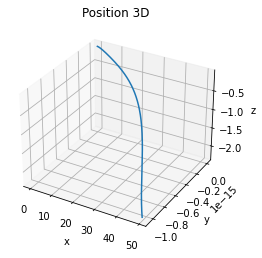

In [11]:
ax = plt.axes(projection='3d')
ax.plot3D(x,y,z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Position 3D')
plt.show()


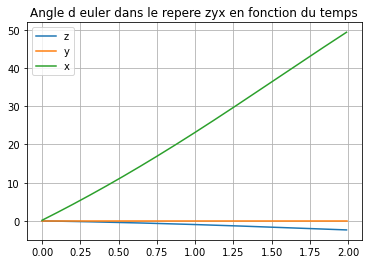

In [12]:
plt.plot(arange(0,N*dt,dt),z, label='z')
plt.plot(arange(0,N*dt,dt),y, label='y')
plt.plot(arange(0,N*dt,dt),x, label='x')
plt.grid()
plt.title('Angle d euler dans le repere zyx en fonction du temps')
plt.legend()
plt.show()

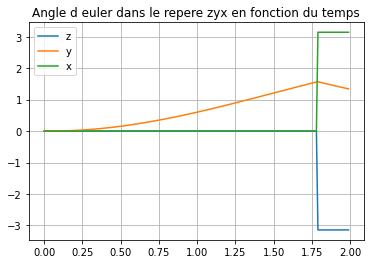

In [13]:
angle = np.reshape(angle,(N,3))
plt.plot(arange(0,N*dt,dt),angle[:,0], label='z')
plt.plot(arange(0,N*dt,dt),angle[:,1], label='y')
plt.plot(arange(0,N*dt,dt),angle[:,2], label='x')
plt.grid()
plt.title('Angle d euler dans le repere zyx en fonction du temps')
plt.legend()
plt.show()


# Exportation des fonctions lambdifiées pour la simulation

In [14]:
import dill as dill
dill.settings['recurse'] = True

Functions = [VelinLDPlane_function, dragDirection_function, liftDirection_function, compute_alpha_sigma, Coeff_function, Effort_Aero_function]
dill.dump(Functions, open("./fichier_function", "wb"))


In [15]:
Dict_etats = {"position" : X, "vitesse" : V, "acceleration" : Accel, "orientation" : q, "vitesse_angulaire" : Omega, "accel_angulaire" : OmegaP}
Dict_parametres = {"masse": m , "inertie": J, "alpha0" :alpha_0, "alpha_stall" : alpha_s, "largeur_stall" : delta_s, "wind" : v_W}
Dict_variables = {"cd0sa" : cd0sa, "cl1fp" : cl1fp, "cd1sa" : cd1sa, "cd0fp" : cd0sa, "cl1sa" : cl1sa, "cd1fp" : cd1fp, "coeff_drag_shift":k0, "coeff_lift_shift":k1, "coef_lift_gain":k2 }
Dict_commande = {"delta" : delta}
